1. fetch patch embeddings of a single patch from a WSI
2. generate 2 (more later) augmentations of this embedding
3. get the absolute difference of each dimension in the augmentations
4. sum each row into different buckets
5. get distribution for the differences of each dimension
6. normalise distribution between 0 and 1
7. plot on histogram
8. repeat 10 times

In [1]:
import os
import torch
import numpy as np

import cv2
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from augmentations.augmentations import aug_combined, aug_rotation


/home/guillaume/anaconda3/envs/imaad/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/guillaume/anaconda3/envs/imaad/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
slide_dir = "/media/disk2/prostate/SICAPv2/wsis"
data_root = "/media/disk2/proj_embedding_aug"
extracted_dir = "extracted_mag40x_patch256_fp"
patches_path = os.path.join(data_root, extracted_dir, "patches")

PATCH_SIZE = 256

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

torch.autograd.set_grad_enabled(False)

In [3]:
from torchvision import transforms
from utils.resnet_custom import resnet50_baseline

def eval_transforms(pretrained=False):
    if pretrained:
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)

    else:
        mean = (0.5, 0.5, 0.5)
        std = (0.5, 0.5, 0.5)

    trnsfrms_val = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
    )

    return trnsfrms_val

model = resnet50_baseline(pretrained=True)
model.to(device)
model.eval()

roi_transforms = eval_transforms(pretrained=True)



In [4]:
def load_patch_img(slide_path, h5_path, patch_size=256, patch_index=0):
    with h5py.File(h5_path, "r") as f:
        patch_coords = f["coords"][()]
        x, y = patch_coords[patch_index]

        slide = Image.open(slide_path)
        slide.load()
        
        image = slide.crop((x, y, x + patch_size, y + patch_size))
        image.load()

        image = np.array(image)

        return image

def get_patch_embs(patch_img):
    patch_img = roi_transforms(patch_img).unsqueeze(0)
    patch_img = patch_img.to(device)

    patch_embs = model(patch_img)
    return patch_embs

def get_true_augmentation(patch_img, aug):
    aug_embs = aug(patch_img)
    return aug_embs

def generate_augmentation(patch_embs):
    # import generator
    from generator import GeneratorMLP

    # load model
    dagan_run_code = "gan_mlp_s1_lr1e-03_None_b64_20221909_182052"
    dagan_state_path = f"/home/guillaume/Documents/uda/project-augmented-embeddings/2-dagan/results/sicapv2/{dagan_run_code}/s_4_checkpoint.pt"
    dagan_state_dict = torch.load(dagan_state_path)

    n_tokens = 1024
    dropout = 0.2
    generator = GeneratorMLP(n_tokens, dropout)

    generator.load_state_dict(dagan_state_dict["G_state_dict"])

    generator.eval().to(device)
    # print(generator)

    with torch.no_grad():
        patch_embs = patch_embs.to(device)
        noise = torch.randn(patch_embs.size(0), patch_embs.size(1), requires_grad=False).to(device)
        # print("patch_embs", patch_embs)
        # print("noise", noise)
        # print("device - patch_embs:", patch_embs.device)
        # print("device - noise:", noise.device)
        aug_embs = generator.forward(patch_embs, noise)
    
    return aug_embs
        
def get_distribution(a, b):
    distribution = []
    # sum absolute differences for each dimension
    abs_diff = torch.abs(torch.sub(a, b))

    # normalise distribution between 0 and 1
    distribution = abs_diff
    # distribution -= distribution.min()
    # distribution /= distribution.max()

    return distribution

def get_distribution_for_patch(slide_id, patch_index, aug, mode):
    slide_path = os.path.join(slide_dir, slide_id + ".png")
    h5_path = os.path.join(patches_path, slide_id + "_patches.h5")

    patch_img = load_patch_img(slide_path, h5_path, patch_size=256, patch_index=0)
    x = get_patch_embs(patch_img).to(device)

    if mode == "true":
        aug = get_true_augmentation(patch_img, aug_combined)
        x_aug = get_patch_embs(aug)
    elif mode == "gen":
        x_aug = generate_augmentation(x)

    distribution = get_distribution(x, x_aug)
    distribution = np.squeeze(distribution, axis=0)
    distribution = distribution.cpu().detach().numpy()

    return distribution

In [5]:
from torch import Tensor

save_dir = "graphs/"

# mode = input("Enter mode (true/gen): ")

aug_fns = {
    "combined": aug_combined,
    "rotation": aug_rotation
}

# aug_key = input("Enter aug key: ")
slide_id = "16B0003394"

def run(mode, aug_key):
    ds = []
    n = 10
    for i in range(n):
        print("patch:", i)
        d = get_distribution_for_patch(slide_id, patch_index=i, aug=aug_fns[aug_key], mode=mode)
        ds.append(d)

    # mean
    dist = np.mean(np.stack(ds, axis=0), axis=0)

    return dist

dists = []

dists.append(run("true", "combined"))
dists.append(run("gen", "combined"))
    

print(dists)

patch: 0
patch: 1
patch: 2
patch: 3
patch: 4
patch: 5
patch: 6
patch: 7
patch: 8
patch: 9
patch: 0
patch: 1
patch: 2
patch: 3
patch: 4
patch: 5
patch: 6
patch: 7
patch: 8
patch: 9
[array([0.00853474, 0.0092258 , 0.00630635, ..., 0.01402078, 0.0019761 ,
       0.01036701], dtype=float32), array([0.20751365, 0.2972093 , 0.36765108, ..., 0.8358143 , 0.81108105,
       0.40372053], dtype=float32)]


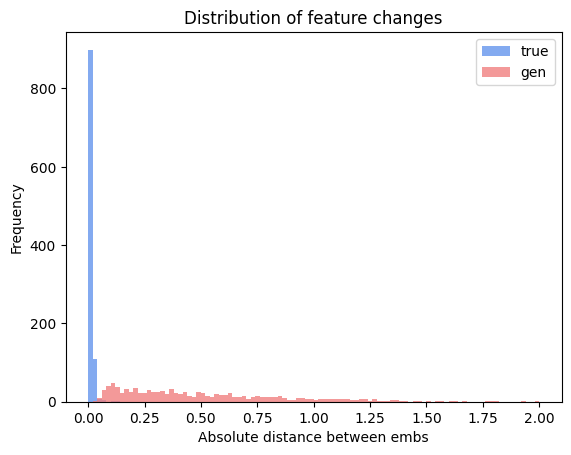

In [20]:
import matplotlib.pyplot as plt

# plot histograms
n_bins = 100

plt.clf()
# reset the plot configurations to default
plt.rcdefaults()
# set the axes color glbally for all plots
plt.rcParams.update({'axes.facecolor':'white'})

plt.title(f"Distribution of feature changes")
plt.xlabel(f"Absolute distance between embs")
plt.ylabel("Frequency")
# plt.xlim([0.0, 2.0])
# plt.ylim([0, 1024])

# labels = [str(l) for l in range(n)]
bin_width = 2.0 / 100
plt.hist(dists[0], bins=np.arange(0, 2 + bin_width, bin_width), color='cornflowerblue', alpha=0.8, label='true')
plt.hist(dists[1], bins=np.arange(0, 2 + bin_width, bin_width), color='lightcoral', alpha=0.8, label='gen')

# plt.hist(dists, bins=n_bins, label=["true", "gen"], alpha=0.5)
plt.legend(loc='upper right')
# plt.hist(dist_mean, bins=np.arange(0, 1 + bin_width, bin_width))
plt.savefig(os.path.join(save_dir, f"{slide_id}_dist.png"))

In [16]:
plt.clf()
# reset the plot configurations to default
plt.rcdefaults()
# set the axes color glbally for all plots
plt.rcParams.update({'axes.facecolor':'white'})

<Figure size 432x288 with 0 Axes>

[   0    1    2 ... 1021 1022 1023]
[array([0.00853474, 0.0092258 , 0.00630635, ..., 0.01402078, 0.0019761 ,
       0.01036701], dtype=float32), array([0.20751365, 0.2972093 , 0.36765108, ..., 0.8358143 , 0.81108105,
       0.40372053], dtype=float32)]


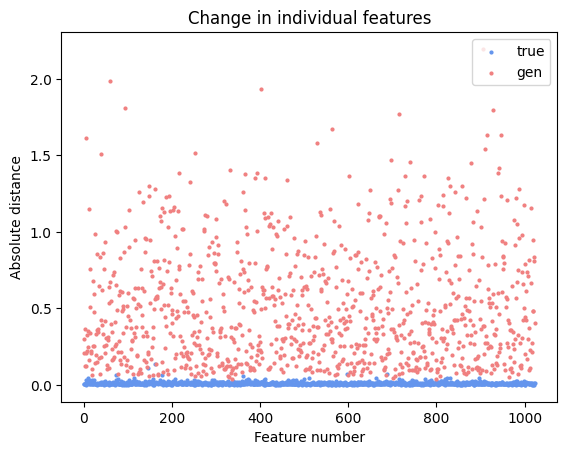

In [22]:
x = np.arange(0, len(dists[0]))
y = dists

print(x)
print(y)
plt.title(f"Change in individual features")
plt.xlabel("Feature number")
plt.ylabel("Absolute distance")
# plt.xlim([0, 1024])
# plt.ylim([0.0, 1.0])
plt.scatter(x, y[0], s=4, c='cornflowerblue', label='true')
plt.scatter(x, y[1], s=4, c='lightcoral', label='gen')
plt.legend(loc='upper right')
plt.savefig(os.path.join(save_dir, f"{slide_id}_features.png"))